In [68]:
from mppi import Utilities as U, Parsers as P

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

from scipy import integrate as I

hplanck = U.Planck_ev_ps*1e3 # Planck constant in ev*fs

# Analysis of the effect of the pulse width

We consider the results of two different computation performed with pumps of width 100 and 400 fs. 
The grid of k points is the same in the two computations.

In [5]:
path_nscf = 'NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml'

path100 = 'RT_k200/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'
path400 = 'RT_k200/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000-width_400/'

In [6]:
qedata = P.PwParser(path_nscf)

data100 = P.YamboParser.from_path(path100)
data400 = P.YamboParser.from_path(path400)

field100 = data100['external_field']
carriers100 = data100['carriers']
spin100 = data100['spin_magnetization']

field400 = data400['external_field']
carriers400 = data400['carriers']
spin400 = data400['spin_magnetization']

Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml


## Real time results

We compare the results of the degree of spin polarization in the two cases.

We start looking at the profile of the field intensity. The time_shift is used to set the maximum of the fields
at the same time

In [16]:
time_shift = 380

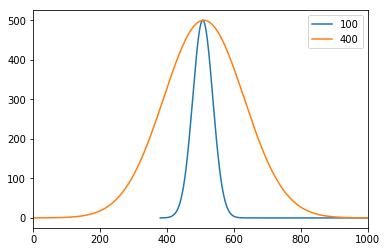

In [17]:
plt.plot(field100['time']+time_shift,field100['Intensity'],label=100)
plt.plot(field400['time'],field400['Intensity'],label=400)
plt.xlim(0,1000)
plt.legend()

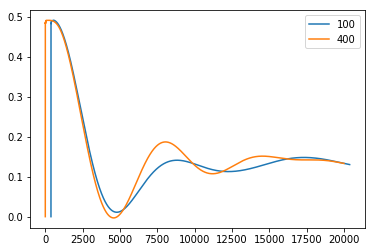

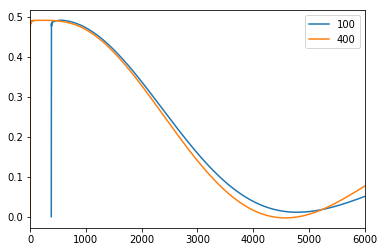

In [22]:
plt.plot(spin100['time']+time_shift,spin100['Mc_z'],label=100)
plt.plot(spin400['time'],spin400['Mc_z'],label=400)
plt.legend()
plt.show()

plt.plot(spin100['time']+time_shift,spin100['Mc_z'],label=100)
plt.plot(spin400['time'],spin400['Mc_z'],label=400)
plt.xlim(0,6000)
plt.legend()

Some comments:

* The signal dephasing time is equal in the two cases. This means that the maximum frequencies that contribute
 to the two curves are almost the same
 
* The curve for width=400 has higher oscillations for long time, this could mean that less k points are involved
  by this pump

To confirm these behavior we also consider two further resutls, related to the width=100 pump, but
performed with a grid made of different k points and in a extented sampling region.

In [25]:
path100v1 = 'RT_k200_v1/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'
path100ext = 'RT_k200_kspan0.07/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000/'

In [26]:
data100v1 = P.YamboParser.from_path(path100v1)
data100ext = P.YamboParser.from_path(path100ext)

field100v1 = data100v1['external_field']
carriers100v1 = data100v1['carriers']
spin100v1 = data100v1['spin_magnetization']

field100ext = data100ext['external_field']
carriers100ext = data100ext['carriers']
spin100ext = data100ext['spin_magnetization']

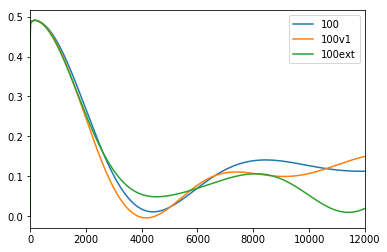

In [32]:
plt.plot(spin100['time'],spin100['Mc_z'],label=100)
plt.plot(spin100v1['time'],spin100v1['Mc_z'],label='100v1')
plt.plot(spin100ext['time'],spin100ext['Mc_z'],label='100ext')
plt.xlim(0,12000)
plt.legend()
plt.show()

We observe that the time profile of the dephasing of the signal is the same

## Analysis JDOS for cc' transitions

We build the JDOS for the cc' transitions im the various cases.

First of all we compute the JDOS associated to standard and the extended k sampling region

In [45]:
path_nscf_ext = 'NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml'
qedata_ext = P.PwParser(path_nscf_ext)

Parse file : NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma_kspan0.07.save/data-file-schema.xml


In [46]:
tr = 1e3*qedata.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
trext = 1e3*qedata_ext.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

w = qedata.weights
wext = qedata_ext.weights

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.545614745375495 eV


From these transitions we can compute the JDOS

In [47]:
jdos = U.Dos()
jdos.append_fromPwData(tr,w,minVal=-2,maxVal=3,eta=0.05,label='tr')
jdos.append_fromPwData(trext,wext,minVal=-2,maxVal=3,eta=0.05,label='$trext')

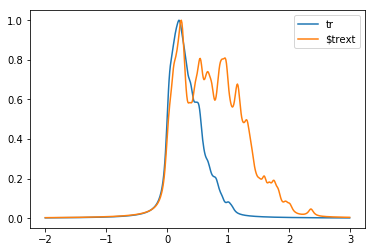

In [48]:
jdos.plot(plt,rescale=True)
plt.legend()

The JDOS are different and if we computed the average of the cosine function we obtain:

In [52]:
eng = jdos.dos[0][0]
values = jdos.dos[0][1]
values_ext = jdos.dos[1][1]

In [53]:
norm = I.simps(y=values,x=eng)
norm_ext = I.simps(y=values_ext,x=eng)

In [59]:
nus = eng/(U.Planck_ev_ps*1e3)
omegas = 2.0*np.pi*nus

In [60]:
tvals = np.linspace(0,20,200)

In [61]:
res = []
res_ext = []
for t in tvals:
    integrand = values*np.cos(omegas*t)
    res.append(1/norm*I.simps(y=integrand,x=eng))
    integrand_ext = values_ext*np.cos(omegas*t)
    res_ext.append(1/norm*I.simps(y=integrand_ext,x=eng))
res = np.array(res)
res_ext= np.array(res_ext)

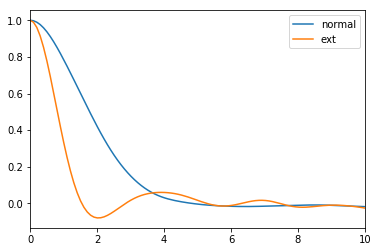

In [63]:
plt.plot(tvals,res,label='normal')
plt.plot(tvals,res_ext,label='ext')
plt.xlim(0,10)
plt.legend()

According to this analysis the signal computed in the wider samplign region should dephase faster.
However this analysis does not take into account the width of the field, so that only the transitions
inside the width of the field can be activated by the pump.

### Inclusion of the effects of the width of the pump

We evaluate the spectral width of the pump of temporal width of 100 fs by computing its FT

In [76]:
dt100 = field100['time'][1]-field100['time'][0]
Ex100 = field100['Ex_Re']
N100 = Ex100.size

In [104]:
freq100 = np.fft.fftfreq(N100, d=dt100)
freq100plus = freq100[0:int(N100/2)]
Ex100FT = np.fft.fft(Ex100)
Int100FT = np.sqrt(Ex100FT.real**2+Ex100FT.imag**2)
Int100FT = Int100FT/Int100FT.max()
Int100FTplus = Int100FT[0:int(N100/2)]

(1.3, 1.7)

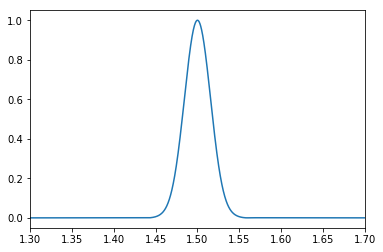

In [105]:
plt.plot(hplanck*freq100plus,Int100FTplus)
plt.xlim(1.3,1.7)

The width of the pump has to be taken into account in the JDOS cv that select the 
transitions that are activated by the pump. Only these transitions contribute to the 
JDOS cc'.

In [92]:
trcv = qedata.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])
trcvext = qedata_ext.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.545614745375495 eV


In [95]:
jdos_cv = U.Dos()
jdos_cv.append_fromPwData(trcv,w,minVal=1,maxVal=2,eta=0.004,label='normal')
jdos_cv.append_fromPwData(trcvext,wext,minVal=1,maxVal=2,eta=0.004,label='extended')

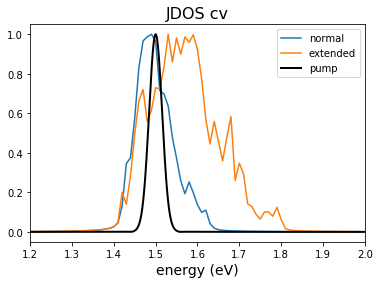

In [281]:
jdos_cv.plot(plt,rescale=True)
plt.plot(hplanck*freq100plus,Int100FTplus,c='black',linewidth=2,label='pump')
plt.xlim(1.2,2)
plt.title('JDOS cv',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()

We have to select only the transitions inside the pulse width

In [116]:
trcv[2]

array([1.61882739, 1.61914296, 1.61801277, 1.61832835, 1.53617924,
       1.53649482, 1.53616332, 1.53647889])

In [239]:
def is_activated(t,epump,spread):
    emin = epump-1e-3*spread*0.5
    emax = epump+1e-3*spread*0.5
    t1 = np.mean(t[0:4])
    t2 = np.mean(t[4:])
    inside1 = emin <= t1 <= emax
    inside2 = emin <= t2 <= emax
    return np.all([inside1,inside2])

def get_kactivated(ttcv,epump,spread):
    kact = []
    for ind,t in enumerate(ttcv):
        if is_activated(t,epump,spread):
            kact.append(ind)
    return kact

def select_transitions(ttcv,ttcc,epump=1.5,spread=40):
    kact = get_kactivated(ttcv,epump,spread)
    ttcvact = []
    ttccact = []
    for k in kact:
        ttcvact.append(ttcv[k])
        ttccact.append(ttcc[k])
    return np.array(ttcvact).flatten(),np.array(ttccact).flatten()

In [269]:
spread = 80

In [270]:
tractcv, tract = select_transitions(trcv,tr,spread=spread)
tractcv_ext, tract_ext = select_transitions(trcvext,trext,spread=spread)

In [278]:
tr.size

200

In [274]:
tract.size

81

In [277]:
tract_ext.size

25

In [271]:
jdoscvact = U.Dos()
jdoscvact.append(tractcv,minVal=1,maxVal=2,eta=0.004,label='normal')
jdoscvact.append(tractcv_ext,minVal=1,maxVal=2,eta=0.004,label='extended')

jdosccact = U.Dos()
jdosccact.append(tract,minVal=-2,maxVal=2,eta=0.05,label='normal')
jdosccact.append(tract_ext,minVal=-2,maxVal=2,eta=0.05,label='extended')

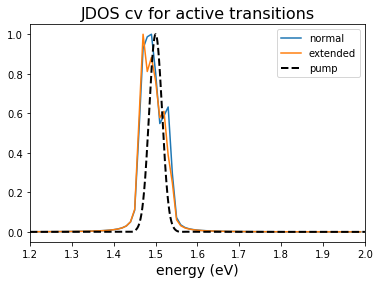

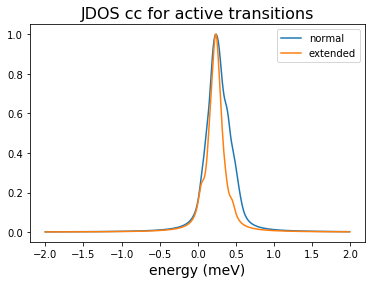

In [280]:
jdoscvact.plot(plt,rescale=True)
plt.plot(hplanck*freq100plus,Int100FTplus,c='black',linewidth=2,linestyle='--',label='pump')
plt.xlim(1.2,2)
plt.title('JDOS cv for active transitions',size=16)
plt.xlabel('energy (eV)',size=14)
plt.legend()
plt.show()

jdosccact.plot(plt,rescale=True)
#plt.xlim(1.2,2)
plt.title('JDOS cc for active transitions',size=16)
plt.xlabel('energy (meV)',size=14)
plt.legend()

This plot shows how the field selects the transitions. The average of the cosine with this distributions is

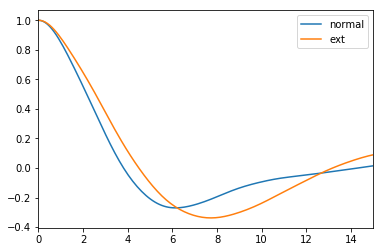

In [273]:
eng = jdosccact.dos[0][0]
values = jdosccact.dos[0][1]
values_ext = jdosccact.dos[1][1]

norm = I.simps(y=values,x=eng)
norm_ext = I.simps(y=values_ext,x=eng)

nus = eng/(U.Planck_ev_ps*1e3)
omegas = 2.0*np.pi*nus

tvals = np.linspace(0,20,200)

res = []
res_ext = []
for t in tvals:
    integrand = values*np.cos(omegas*t)
    res.append(1/norm*I.simps(y=integrand,x=eng))
    integrand_ext = values_ext*np.cos(omegas*t)
    res_ext.append(1/norm*I.simps(y=integrand_ext,x=eng))
res = np.array(res)
res_ext= np.array(res_ext)

plt.plot(tvals,res,label='normal')
plt.plot(tvals,res_ext,label='ext')
plt.xlim(0,15)
plt.legend()

Thanks to the selection performed by the pump the time profile of the dephasing is (almost) equal, 
in agreement with the result of the rt computation

In [ ]:
##########################################################################

In [197]:
is_activated(trcv[2],epump=1.5,spread=80)

False

In [198]:
spread = 80

In [199]:
kact = []
kact_ext = []
for ind,t in enumerate(trcv):
    if is_activated(t,spread=spread):
        kact.append(ind)
        
for ind,t in enumerate(trcvext):
    if is_activated(t,spread=spread):
        kact_ext.append(ind)

In [200]:
tract = []
tract_ext = []
for k in kact:
    tract.append(tr[k][0])
for k in kact_ext:
    tract_ext.append(trext[k][0])

    
tract = np.array(tract)
tract_ext = np.array(tract_ext)

In [201]:
tract.size

174

In [202]:
tract_ext.size

70

In [161]:
jdosact = U.Dos()
jdosact.append(tract,minVal=-2,maxVal=3,eta=0.05,label='normal')
jdosact.append(tract_ext,minVal=-2,maxVal=3,eta=0.05,label='extended')

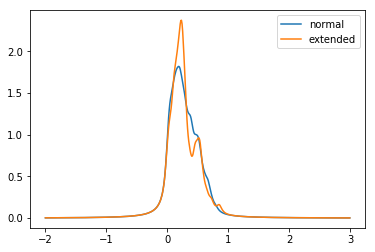

In [162]:
jdosact.plot(plt)
plt.legend()

This plot shows how the field selects the transitions. The average of the cosine with this distributions is

In [163]:
eng = jdosact.dos[0][0]
values = jdosact.dos[0][1]
values_ext = jdosact.dos[1][1]

norm = I.simps(y=values,x=eng)
norm_ext = I.simps(y=values_ext,x=eng)

nus = eng/(U.Planck_ev_ps*1e3)
omegas = 2.0*np.pi*nus

tvals = np.linspace(0,20,200)

res = []
res_ext = []
for t in tvals:
    integrand = values*np.cos(omegas*t)
    res.append(1/norm*I.simps(y=integrand,x=eng))
    integrand_ext = values_ext*np.cos(omegas*t)
    res_ext.append(1/norm*I.simps(y=integrand_ext,x=eng))
res = np.array(res)
res_ext= np.array(res_ext)

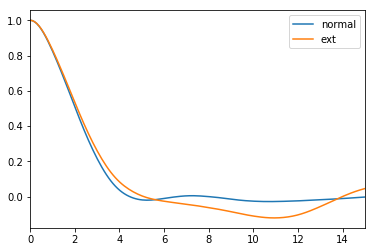

In [164]:
plt.plot(tvals,res,label='normal')
plt.plot(tvals,res_ext,label='ext')
plt.xlim(0,15)
plt.legend()

The time profile of the dephasing is equal, in agreement with the result of the rt computation